In [1]:
import pandas as pd
import seaborn as sns 
import numpy as np
import glob
import matplotlib.pyplot as plt
from scipy.stats import sem
%matplotlib inline
%config Completer.use_jedi = False


#import required sklearn for random forest classifier

import sklearn as sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix,roc_auc_score, f1_score, make_scorer
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold, RepeatedKFold, cross_validate
from sklearn.feature_selection import mutual_info_classif,VarianceThreshold, SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [2]:
#Import FPKM data for all cancers matched with tissue / cancer status

all_cancers_file = '/Users/jake/OneDrive - University of Glasgow/Project/Cancer Stratification/all_cancers_SS_filtered.csv'
all_cancers = pd.read_csv(all_cancers_file,header=[0,1],sep='\t',index_col=[0])

In [3]:
all_cancers

Gene_symbol,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,Cancer_tissue_status
Gene_ensembl_id,ENSG00000121410,ENSG00000148584,ENSG00000175899,ENSG00000166535,ENSG00000184389,ENSG00000128274,ENSG00000118017,ENSG00000094914,ENSG00000081760,ENSG00000114771,...,ENSG00000174442,ENSG00000122952,ENSG00000198205,ENSG00000198455,ENSG00000070476,ENSG00000203995,ENSG00000162378,ENSG00000159840,ENSG00000074755,Cancer_tissue_status
TCGA-BH-A1FN,0.208011,0.009381,43.292960,0.055509,0.110075,3.581380,0.038150,5.007168,1.640055,0.000000,...,4.351933,24.207158,1.127985,3.549771,7.245900,2.346176,12.914487,41.879917,3.253812,BRCA_1
TCGA-E9-A1NG,0.108386,0.004110,178.373384,0.327900,0.000000,7.944528,0.022288,7.198746,2.232691,0.000000,...,4.018591,7.967490,0.985287,2.102866,2.553868,0.058864,6.947852,67.347728,2.725455,BRCA_1
TCGA-AC-A23H,0.020294,0.002822,37.866925,0.395196,0.000000,1.740345,0.007651,8.431803,6.124952,0.032494,...,3.705314,20.387417,1.722966,7.227800,7.604626,0.825575,6.627812,70.866135,5.747454,BRCA_1
TCGA-A7-A0DC,0.660110,0.131949,55.782077,0.746827,0.269265,1.928116,0.217754,9.173075,4.806061,1.023887,...,2.624497,2.756902,2.866430,6.842064,14.519888,0.246469,6.343812,17.736301,17.258228,BRCA_1
TCGA-BH-A0BA,0.146119,0.014777,123.459875,0.240457,0.000000,3.357131,0.040063,10.716496,23.238758,0.510444,...,6.127255,20.796211,2.328833,5.314763,4.388074,1.277253,6.348272,45.638784,5.031597,BRCA_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-EL-A3T6,0.166550,0.004737,46.248647,0.031145,0.088936,4.158023,0.051373,8.959670,2.018176,0.172727,...,1.688672,2.863111,1.563187,3.586380,4.987906,0.888369,5.081061,124.884518,4.719659,THCA_0
TCGA-EM-A1CT,0.095714,0.000000,38.841957,0.015557,0.083291,5.891831,0.000000,8.641519,2.370101,0.025542,...,1.686923,3.033729,1.905922,3.987611,4.574804,1.098218,7.802169,14.486686,4.200076,THCA_0
TCGA-EM-A1CU,0.027703,0.005778,36.442801,0.035458,0.000000,2.344291,0.135774,7.603383,2.085959,0.022178,...,1.659320,4.091353,2.603832,5.334968,5.488403,2.151506,12.835744,15.766241,4.772690,THCA_0


In [4]:
#Load all trans_95 95 csvs for all cancer types 

BRCA_trans_95_file = '/Users/jake/OneDrive - University of Glasgow/Project/BRCA/eQTL/eQTL_95/BRCA_trans_eQTL_95_ensembl.csv'
KIRC_trans_95_file = '/Users/jake/OneDrive - University of Glasgow/Project/KIRC/eQTL/eQTL_95/KIRC_trans_eQTL_95_ensembl.csv'
LUAD_trans_95_file = '/Users/jake/OneDrive - University of Glasgow/Project/LUAD/eQTL/eQTL_95/LUAD_trans_eQTL_95_ensembl.csv'
THCA_trans_95_file = '/Users/jake/OneDrive - University of Glasgow/Project/THCA/eQTL/eQTL_95/THCA_trans_eQTL_95_ensembl.csv'

BRCA_trans_95 = pd.read_csv(BRCA_trans_95_file,sep='\t')
KIRC_trans_95 = pd.read_csv(KIRC_trans_95_file,sep='\t')
LUAD_trans_95 = pd.read_csv(LUAD_trans_95_file,sep='\t')
THCA_trans_95 = pd.read_csv(THCA_trans_95_file,sep='\t')

In [5]:
#Check for missing values

all_cancers.isnull().sum().sort_values(ascending=False)

Gene_symbol           Gene_ensembl_id     
A1BG                  ENSG00000121410         0
PPP1R9A               ENSG00000158528         0
PPP2R2B               ENSG00000156475         0
PPP2R2A               ENSG00000221914         0
PPP2R1B               ENSG00000137713         0
                                             ..
GBP6                  ENSG00000183347         0
GBP5                  ENSG00000154451         0
GBP4                  ENSG00000162654         0
GBP3                  ENSG00000117226         0
Cancer_tissue_status  Cancer_tissue_status    0
Length: 19536, dtype: int64

In [6]:
#Can now perform PCA 

#First split data into features and target
X_matched = all_cancers.drop(['Cancer_tissue_status'],axis=1,level=0)
y_matched = all_cancers['Cancer_tissue_status','Cancer_tissue_status']

#Then need to scale data
X_pca_macthed = StandardScaler().fit_transform(X_matched.values)

X_pca_df_matched = pd.DataFrame(X_pca_macthed, index=X_matched.index, columns=X_matched.columns)

#Now create 2 component PCA

pca_matched = PCA(n_components=2)
principal_comp_matched = pca_matched.fit_transform(X_pca_df_matched)
pca_df_macthed = pd.DataFrame(data = principal_comp_matched, columns = ['PC 1', 'PC 2'],index=X_matched.index)

#Now concat the pca_df with the target cancer col
final_pca_df_matched = pd.concat([pca_df_macthed, y_matched], axis = 1)
final_pca_df_matched

,PC 1,PC 2,"(Cancer_tissue_status, Cancer_tissue_status)"
TCGA-BH-A1FN,57.254145,-41.049747,BRCA_1
TCGA-E9-A1NG,8.069495,-8.413101,BRCA_1
TCGA-AC-A23H,31.328148,-47.987554,BRCA_1
TCGA-A7-A0DC,227.189805,-1.635014,BRCA_1
TCGA-BH-A0BA,50.506227,-35.341712,BRCA_1
...,...,...,...
TCGA-EL-A3T6,-22.808395,-13.800676,THCA_0
TCGA-EM-A1CT,-18.936395,-12.003274,THCA_0
TCGA-EM-A1CU,15.246232,6.017810,THCA_0
TCGA-BJ-A2N9,-34.957491,-27.745829,THCA_0


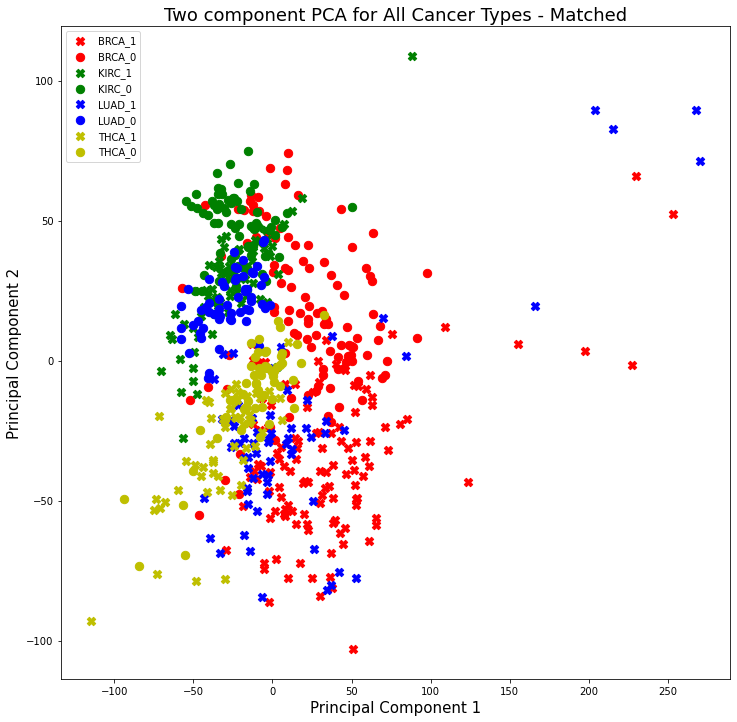

In [7]:
#Now create plot demonstrating the variance in PC 1 and PC 2 between cancer and tissue types when matched

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Two component PCA for All Cancer Types - Matched', fontsize = 18)
targets = list(final_pca_df_matched[('Cancer_tissue_status', 'Cancer_tissue_status')].unique())
colours = ['r','r','g','g','b','b','y','y']

for index, target in enumerate(targets):
    
    if '_1' in target:
    
        indicesToKeep = final_pca_df_matched[('Cancer_tissue_status', 'Cancer_tissue_status')] == target
        ax.scatter(final_pca_df_matched.loc[indicesToKeep, 'PC 1'],
                   final_pca_df_matched.loc[indicesToKeep, 'PC 2'],
                   s = 70,
                  marker = 'X',
                  c = colours[index])
    
    else:
    
        indicesToKeep = final_pca_df_matched[('Cancer_tissue_status', 'Cancer_tissue_status')] == target
        ax.scatter(final_pca_df_matched.loc[indicesToKeep, 'PC 1'],
                   final_pca_df_matched.loc[indicesToKeep, 'PC 2'],
                   s = 70,
                   c = colours[index])
        
ax.legend(targets)

In [8]:
#Now look at PCA for trans filtered genes
#First drop duplicates and then try pancan trans


In [9]:
#Check no duplicates in cancer types individually first

display(sum(BRCA_trans_95.duplicated()))
display(sum(KIRC_trans_95.duplicated()))
display(sum(LUAD_trans_95.duplicated()))
display(sum(THCA_trans_95.duplicated()))

0

0

0

0

In [7]:
#Concat all the different trans_95 switch data into one dataframe

all_trans_95 = pd.concat([BRCA_trans_95,KIRC_trans_95,LUAD_trans_95,THCA_trans_95]).reset_index(drop=True)

all_trans_95.drop('Unnamed: 0',axis=1,inplace=True)

In [8]:
#Drop any duplicated genes in the ensembl_gene_id column

all_trans_unique = all_trans_95.drop_duplicates('ensembl_gene_id')

In [9]:
all_trans_unique['Gene_symbol'].nunique()

337

In [10]:
#Now filter the genes / columns in X_matched in relation to the trans_95_unique genes

X_trans_unique = X_matched.loc(axis=1)[:, list(all_trans_unique['ensembl_gene_id'])]

In [11]:
#Now try a PCA on the isform filtered, matched data to see if increases the variance between the dif cancer types

X_pca_trans_unique = StandardScaler().fit_transform(X_trans_unique.values)

X_pca_df_trans_unique = pd.DataFrame(X_pca_trans_unique, index=X_trans_unique.index, columns=X_trans_unique.columns)

pca_trans_unique = PCA(n_components=2)

principal_comp_trans_unique = pca_trans_unique.fit_transform(X_pca_df_trans_unique)

pca_df_trans_unique = pd.DataFrame(data = principal_comp_trans_unique, columns = ['PC 1', 'PC 2'],index=X_trans_unique.index)

final_pca_df_trans_unique = pd.concat([pca_df_trans_unique, y_matched], axis = 1)
final_pca_df_trans_unique

,PC 1,PC 2,"(Cancer_tissue_status, Cancer_tissue_status)"
TCGA-BH-A1FN,15.627461,9.945380,BRCA_1
TCGA-E9-A1NG,0.587064,-1.411788,BRCA_1
TCGA-AC-A23H,1.701712,9.544002,BRCA_1
TCGA-A7-A0DC,15.859262,-6.273329,BRCA_1
TCGA-BH-A0BA,5.723745,1.090996,BRCA_1
...,...,...,...
TCGA-EL-A3T6,-2.017457,0.875700,THCA_0
TCGA-EM-A1CT,0.041724,5.140594,THCA_0
TCGA-EM-A1CU,6.184681,1.951437,THCA_0
TCGA-BJ-A2N9,-4.819171,5.306662,THCA_0


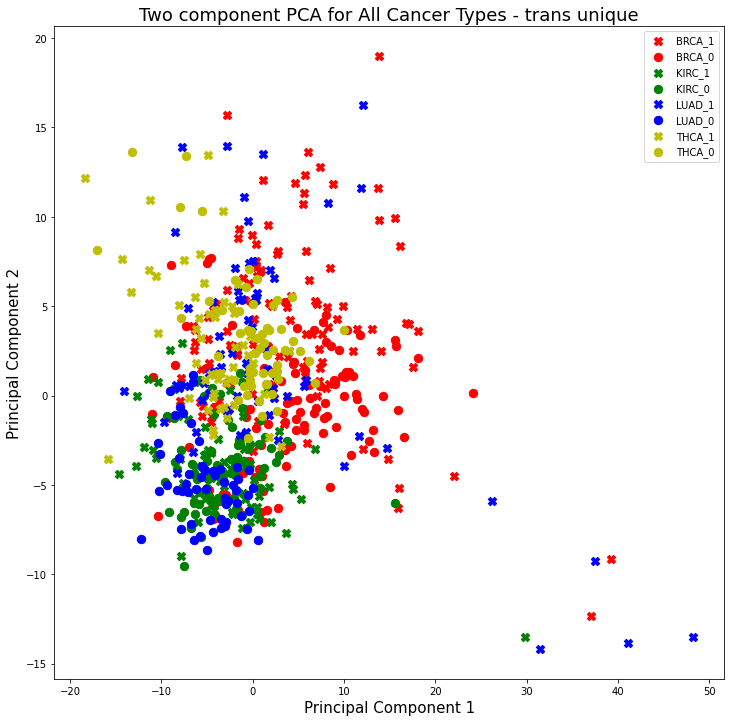

In [15]:
#Now create plot demonstrating the variance in PC 1 and PC 2 between cancer and tissue types when matched

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Two component PCA for All Cancer Types - trans unique', fontsize = 18)
targets = list(final_pca_df_trans_unique[('Cancer_tissue_status', 'Cancer_tissue_status')].unique())
colours = ['r','r','g','g','b','b','y','y']

for index, target in enumerate(targets):
    
    if '_1' in target:
    
        indicesToKeep = final_pca_df_trans_unique[('Cancer_tissue_status', 'Cancer_tissue_status')] == target
        ax.scatter(final_pca_df_trans_unique.loc[indicesToKeep, 'PC 1'],
                   final_pca_df_trans_unique.loc[indicesToKeep, 'PC 2'],
                   s = 70,
                  marker = 'X',
                  c = colours[index])
    
    else:
    
        indicesToKeep = final_pca_df_trans_unique[('Cancer_tissue_status', 'Cancer_tissue_status')] == target
        ax.scatter(final_pca_df_trans_unique.loc[indicesToKeep, 'PC 1'],
                   final_pca_df_trans_unique.loc[indicesToKeep, 'PC 2'],
                   s = 70,
                   c = colours[index])
        
ax.legend(targets)

In [16]:
#Now replicate but for pancan trans genes

In [12]:
#Create new pancan DF by keeping only the trans 95 genes that are duplicated => set keep = False

trans_pancan = all_trans_95[all_trans_95.duplicated(subset='ensembl_gene_id',keep=False)]

In [13]:
#Now drop duplicates 

trans_pancan.drop_duplicates('ensembl_gene_id',inplace=True)

/Users/jake/opt/anaconda3/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [14]:
trans_pancan['ensembl_gene_id'].nunique()

33

In [15]:
#Save the pancan trans 95file to a csv

trans_pancan.to_csv('pancan_trans95.csv',sep='\t')

In [16]:
#Now filter the genes / columns in X_matched in relation to the trans_95_unique genes

X_trans_pancan = X_matched.loc(axis=1)[:, list(trans_pancan['ensembl_gene_id'])]

In [17]:
X_trans_pancan

Gene_symbol,BTN3A2,ZFP57,CCAR2,CNOT7,XPO7,ERI1,BIN3,INTS10,MCPH1,TNKS,...,INTS9,PPP2R2A,WRN,ELP3,NBPF14,ZNF90,TXN2,STX19,CHRNA7,CCDC74B
Gene_ensembl_id,ENSG00000186470,ENSG00000204644,ENSG00000158941,ENSG00000198791,ENSG00000130227,ENSG00000104626,ENSG00000147439,ENSG00000104613,ENSG00000147316,ENSG00000173273,...,ENSG00000104299,ENSG00000221914,ENSG00000165392,ENSG00000134014,ENSG00000270629,ENSG00000213988,ENSG00000100348,ENSG00000178750,ENSG00000175344,ENSG00000152076
TCGA-BH-A1FN,4.985915,0.681195,6.883253,10.086561,15.108778,3.089854,1.105643,5.632802,2.354664,4.875450,...,2.933977,12.502350,3.113977,5.197882,1.198934,0.112047,24.235191,0.175037,0.074212,1.626237
TCGA-E9-A1NG,8.839503,0.251026,14.641512,8.756788,13.818248,2.919980,2.806848,7.194539,2.354203,4.885109,...,4.863285,10.614760,3.675859,8.595045,0.775371,0.369193,20.185416,0.454488,0.066175,0.219926
TCGA-AC-A23H,1.443108,14.369499,6.020071,3.484347,7.095567,1.971463,0.729318,3.726252,0.946755,1.324800,...,4.187877,4.456433,1.705152,10.578417,0.492070,0.825124,70.723483,0.526548,0.014100,0.283861
TCGA-A7-A0DC,3.622190,0.000000,5.935807,4.989114,11.243205,1.432298,3.063064,5.269362,3.505580,8.535991,...,3.639085,8.884857,5.691049,6.245089,1.145849,4.089394,12.845773,0.856348,0.076437,1.596149
TCGA-BH-A0BA,8.654868,0.016508,26.720935,11.521640,14.336182,5.881164,4.553392,6.936107,3.560291,6.479489,...,6.252580,11.978350,4.691079,10.366331,0.888654,3.247544,31.634110,3.201408,0.095365,0.292536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-EL-A3T6,6.772177,0.007056,11.206803,9.098465,11.309635,1.512802,4.909051,10.940607,2.177981,2.930968,...,3.629382,8.664116,2.007824,5.933234,0.614506,1.276462,46.075295,0.052379,0.315581,1.466687
TCGA-EM-A1CT,3.759021,0.006608,12.862361,13.078647,14.324522,1.541336,3.303906,11.740950,2.369529,3.874145,...,4.114148,7.357375,2.084556,6.992573,0.594256,1.130443,58.709815,0.220744,0.105906,1.063428
TCGA-EM-A1CU,4.554557,0.000000,10.581645,14.911581,15.851593,1.735238,3.012270,19.552215,3.173287,6.003001,...,4.019863,8.256720,2.675678,6.949112,0.719043,2.193831,42.073108,0.015973,0.256631,1.599443


In [18]:
#Now perform PCA on trans pancan

X_pca_trans_pancan = StandardScaler().fit_transform(X_trans_pancan.values)

X_pca_df_trans_pancan = pd.DataFrame(X_pca_trans_pancan, index=X_trans_pancan.index, columns=X_trans_pancan.columns)

pca_trans_pancan = PCA(n_components=2)

principal_comp_trans_pancan = pca_trans_pancan.fit_transform(X_pca_df_trans_pancan)

pca_df_trans_pancan = pd.DataFrame(data = principal_comp_trans_pancan, columns = ['PC 1', 'PC 2'],index=X_trans_pancan.index)

final_pca_df_trans_pancan = pd.concat([pca_df_trans_pancan, y_matched], axis = 1)
final_pca_df_trans_pancan

,PC 1,PC 2,"(Cancer_tissue_status, Cancer_tissue_status)"
TCGA-BH-A1FN,-0.564387,2.852470,BRCA_1
TCGA-E9-A1NG,1.655084,0.139582,BRCA_1
TCGA-AC-A23H,-4.426578,0.391893,BRCA_1
TCGA-A7-A0DC,0.070423,3.416592,BRCA_1
TCGA-BH-A0BA,5.742281,0.188584,BRCA_1
...,...,...,...
TCGA-EL-A3T6,0.027466,-2.124700,THCA_0
TCGA-EM-A1CT,0.727851,-2.344716,THCA_0
TCGA-EM-A1CU,2.412851,-1.849993,THCA_0
TCGA-BJ-A2N9,0.013828,-2.918962,THCA_0


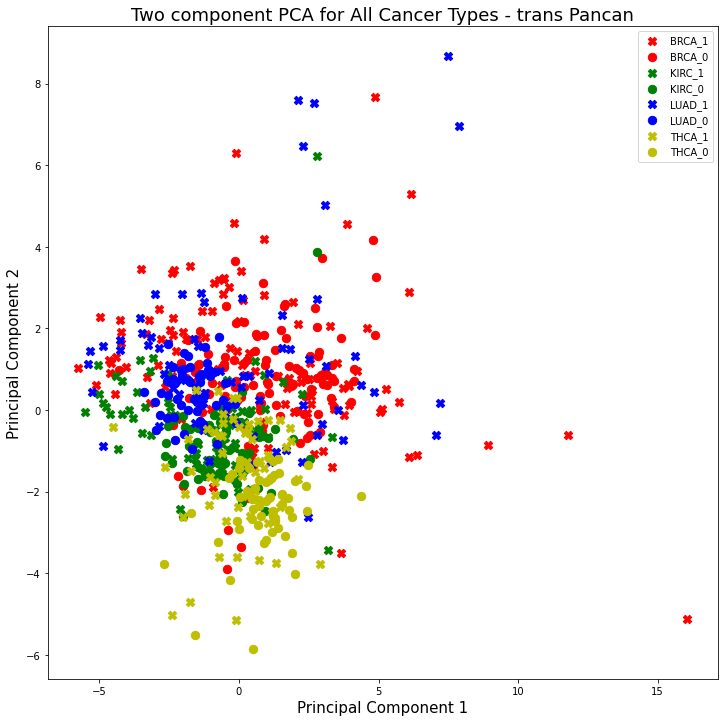

In [24]:
#Now create plot demonstrating the variance in PC 1 and PC 2 between cancer and tissue types when matched

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Two component PCA for All Cancer Types - trans Pancan', fontsize = 18)
targets = list(final_pca_df_trans_pancan[('Cancer_tissue_status', 'Cancer_tissue_status')].unique())
colours = ['r','r','g','g','b','b','y','y']

for index, target in enumerate(targets):
    
    if '_1' in target:
    
        indicesToKeep = final_pca_df_trans_pancan[('Cancer_tissue_status', 'Cancer_tissue_status')] == target
        ax.scatter(final_pca_df_trans_pancan.loc[indicesToKeep, 'PC 1'],
                   final_pca_df_trans_pancan.loc[indicesToKeep, 'PC 2'],
                   s = 70,
                  marker = 'X',
                  c = colours[index])
    
    else:
    
        indicesToKeep = final_pca_df_trans_pancan[('Cancer_tissue_status', 'Cancer_tissue_status')] == target
        ax.scatter(final_pca_df_trans_pancan.loc[indicesToKeep, 'PC 1'],
                   final_pca_df_trans_pancan.loc[indicesToKeep, 'PC 2'],
                   s = 70,
                   c = colours[index])
        
ax.legend(targets)

In [25]:
#Now try Random Forest model on the matched data followed by the trans_95 filtered matched data

In [19]:
#First do label encoding of the target y column

#Make copy of all_cancer

all_cancers_encoded = all_cancers.copy()

le = LabelEncoder()

all_cancers_encoded['Cancer_tissue_status','Cancer_tissue_status'] = le.fit_transform(all_cancers_encoded['Cancer_tissue_status','Cancer_tissue_status'])
all_cancers_encoded

X_encoded = all_cancers_encoded.drop('Cancer_tissue_status',axis=1,level=0)
X_encoded_trans_unique = X_encoded.loc(axis=1)[:, list(all_trans_unique['ensembl_gene_id'])]
X_encoded_trans_pancan = X_encoded.loc(axis=1)[:, list(trans_pancan['ensembl_gene_id'])]

y_encoded = all_cancers_encoded['Cancer_tissue_status','Cancer_tissue_status']

In [20]:
#Create dictionary to see lables created for label encoding

le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping

{'BRCA_0': 0,
 'BRCA_1': 1,
 'KIRC_0': 2,
 'KIRC_1': 3,
 'LUAD_0': 4,
 'LUAD_1': 5,
 'THCA_0': 6,
 'THCA_1': 7}

In [21]:

#Do a train test split to keep out 30% of data for an unseen test set for both matched and unique and pancan trans eQTLs

X_develop_full, X_test_full, y_develop_full, y_test_full = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=19,stratify=y_encoded)

X_develop_trans_unique, X_test_trans_unique, y_develop_trans_unique, y_test_trans_unique = train_test_split(X_encoded_trans_unique, y_encoded, test_size=0.3, random_state=1,stratify=y_encoded)
X_develop_trans_pancan, X_test_trans_pancan, y_develop_trans_pancan, y_test_trans_pancan = train_test_split(X_encoded_trans_pancan, y_encoded, test_size=0.3, random_state=1,stratify=y_encoded)

In [22]:
#Also take a random sample of genes .. same num as unique and pancan

X_random_unique_1 = X_encoded.sample(n=len(X_encoded_trans_unique.columns),axis=1)
X_random_unique_2 = X_encoded.sample(n=len(X_encoded_trans_unique.columns),axis=1)
X_random_unique_3 = X_encoded.sample(n=len(X_encoded_trans_unique.columns),axis=1)

X_develop_trans_unique_ran_1, X_test_trans_unique_ran_1, y_develop_trans_unique_ran_1, y_test_trans_unique_ran_1 = train_test_split(X_random_unique_1, y_encoded, test_size=0.3, random_state=14,stratify=y_encoded)
X_develop_trans_unique_ran_2, X_test_trans_unique_ran_2, y_develop_trans_unique_ran_2, y_test_trans_unique_ran_2 = train_test_split(X_random_unique_2, y_encoded, test_size=0.3, random_state=22,stratify=y_encoded)
X_develop_trans_unique_ran_3, X_test_trans_unique_ran_3, y_develop_trans_unique_ran_3, y_test_trans_unique_ran_3 = train_test_split(X_random_unique_3, y_encoded, test_size=0.3, random_state=33,stratify=y_encoded)



In [23]:
#Pancan random

X_random_pancan_1 = X_encoded.sample(n=len(X_encoded_trans_pancan.columns),axis=1)
X_random_pancan_2 = X_encoded.sample(n=len(X_encoded_trans_pancan.columns),axis=1)
X_random_pancan_3 = X_encoded.sample(n=len(X_encoded_trans_pancan.columns),axis=1)

X_develop_trans_pancan_ran_1, X_test_trans_pancan_ran_1, y_develop_trans_pancan_ran_1, y_test_trans_pancan_ran_1 = train_test_split(X_random_pancan_1, y_encoded, test_size=0.3, random_state=18,stratify=y_encoded)
X_develop_trans_pancan_ran_2, X_test_trans_pancan_ran_2, y_develop_trans_pancan_ran_2, y_test_trans_pancan_ran_2 = train_test_split(X_random_pancan_2, y_encoded, test_size=0.3, random_state=9,stratify=y_encoded)
X_develop_trans_pancan_ran_3, X_test_trans_pancan_ran_3, y_develop_trans_pancan_ran_3, y_test_trans_pancan_ran_3 = train_test_split(X_random_pancan_1, y_encoded, test_size=0.3, random_state=24,stratify=y_encoded)


In [24]:
#First do simple Random Forest with gridsearch to determine optimal parameters

def grid_search_RF(X,y):
    '''Perform Random Forest grid search. Supply development X and y data.'''

    #Random Forest
    classifier = RandomForestClassifier()
    
    #Want to add PCA to pipeline .. up 10 components
    pca = PCA(n_components=10)

    #Pipeline containing Log Reg classifier and Log Reg with deafault settings for feature engineering
    #Also added scaler as error related to iterations / convergance appears, which can be due to 'poor scaling'
    RF_pipeline = Pipeline(steps=[('scale', StandardScaler()),
                                  ('pca',pca),
                                  ('feature_selection', SelectFromModel(RandomForestClassifier())),
                                  ('classifier',classifier)])


    
    #The PCA searches from 1 upto max number of features / genes in 5 steps (since can't search PC's more than max num of features)
    param_grid = {
                'classifier__n_estimators': [50,100,200,300,500],
                #'classifier__max_features': ['auto', 'sqrt', 'log2'],
                #'classifier__criterion' :['gini', 'entropy'],
    }


    #Use repeated stratified k fold to maintian ratio between tumor and normal and do multliple splits of data
    r_stratkfold = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=0)

    #scoring =  roc_auc_ovr since multitarget and ovr accounts for any class imbalance
    grid_search = GridSearchCV(RF_pipeline, param_grid=param_grid, scoring="roc_auc_ovr",cv=r_stratkfold)

    #Fit on development data
    grid_search.fit(X, y)
    
    #Create dictinoary to store the best parameters
    best_params = {}
    
    for k,v in grid_search.best_params_.items():
        
        best_params[k] = v
 
    #Return the best_params dictinoary => run this fuction and save as new variable in relation to what X and y run
    return best_params

In [25]:
#Run the gridsearch for all matched, trans unique and trans pancan


In [26]:
best_params_trans_unique = grid_search_RF(X_develop_trans_unique,y_develop_trans_unique)
best_params_trans_unique

{'classifier__n_estimators': 300}

In [27]:
best_params_trans_unique_ran_1 = grid_search_RF(X_develop_trans_unique_ran_1,y_develop_trans_unique_ran_1)
best_params_trans_unique_ran_2 = grid_search_RF(X_develop_trans_unique_ran_2,y_develop_trans_unique_ran_2)
best_params_trans_unique_ran_3 = grid_search_RF(X_develop_trans_unique_ran_3,y_develop_trans_unique_ran_3)

In [28]:
best_params_trans_pancan = grid_search_RF(X_develop_trans_pancan,y_develop_trans_pancan)
best_params_trans_pancan

{'classifier__n_estimators': 500}

In [29]:
best_params_trans_pancan_ran_1 = grid_search_RF(X_develop_trans_pancan_ran_1,y_develop_trans_pancan_ran_1)
best_params_trans_pancan_ran_2 = grid_search_RF(X_develop_trans_pancan_ran_2,y_develop_trans_pancan_ran_2)
best_params_trans_pancan_ran_3 = grid_search_RF(X_develop_trans_pancan_ran_3,y_develop_trans_pancan_ran_3)

In [37]:
#all genes
best_params_full = grid_search_RF(X_develop_full,y_develop_full)
best_params_full

{'classifier__n_estimators': 500}

In [30]:
# Create a function that cross validates the data

def RF_model_cv(X, y, best_params_dict, repeats = 3, splits = 3):
    '''RF model function. Takes in X and y development data, repeats, splits and the required best_params dictinoary'''

    #First perform RepeatedStratifiedKFold
    r_stratkfold = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats)
    
    # Create classifier with RF model using best_params_iso from gridsearch
    
    classifier = RandomForestClassifier(n_estimators=best_params_dict['classifier__n_estimators'],
                                   #max_features = best_params_dict['classifier__max_features'],
                                   #criterion = best_params_dict['classifier__criterion'], 
                                   random_state=1)
    
    #Create pipleine with scaling, feature selection (set as classifier to add best parameters) and the classifier
    RF_pipeline = Pipeline(steps=[('scale', StandardScaler()),
                                  ('pca',PCA(n_components=10)),
                                   ('feature_selection', SelectFromModel(classifier)),
                                   ('classifier',classifier)])
    
    
    # evaluate the cross_validate
    scores_cv = cross_validate(RF_pipeline, X, y, cv=r_stratkfold,
                            scoring=('f1_weighted','roc_auc_ovr','balanced_accuracy','precision_weighted','recall_weighted'))
    
    #Define performance metrics to return 
    F1 = str(f"Mean F1 weighted = {scores_cv['test_f1_weighted'].mean():.3f} SEM = {sem(scores_cv['test_f1_weighted']):.3f}")
    ROCAUC = str(f"Mean ROCAUC score = {scores_cv['test_roc_auc_ovr'].mean():.3f} SEM = {sem(scores_cv['test_roc_auc_ovr']):.3f} ")
    Accuracy = str(f"Mean balanced accuracy score = {scores_cv['test_balanced_accuracy'].mean():.3f} SEM = {sem(scores_cv['test_balanced_accuracy']):.3f} ")
    Precision = str(f"Mean weighted pretransion = {scores_cv['test_precision_weighted'].mean():.3f} SEM = {sem(scores_cv['test_precision_weighted']):.3f} ")
    Recall = str(f"Mean weighted recall = {scores_cv['test_recall_weighted'].mean():.3f} SEM = {sem(scores_cv['test_recall_weighted']):.3f} ")
    
    return F1, ROCAUC, Accuracy,Precision,Recall

In [31]:
RF_model_cv(X_develop_trans_unique,y_develop_trans_unique,best_params_trans_unique)

('Mean F1 weighted = 0.789 SEM = 0.021',
 'Mean ROCAUC score = 0.967 SEM = 0.006 ',
 'Mean balanced accuracy score = 0.784 SEM = 0.023 ',
 'Mean weighted pretransion = 0.797 SEM = 0.020 ',
 'Mean weighted recall = 0.792 SEM = 0.020 ')

In [32]:
RF_model_cv(X_develop_trans_unique_ran_1,y_develop_trans_unique_ran_1,best_params_trans_unique_ran_1)

('Mean F1 weighted = 0.885 SEM = 0.008',
 'Mean ROCAUC score = 0.989 SEM = 0.002 ',
 'Mean balanced accuracy score = 0.878 SEM = 0.007 ',
 'Mean weighted pretransion = 0.890 SEM = 0.007 ',
 'Mean weighted recall = 0.885 SEM = 0.008 ')

In [33]:
RF_model_cv(X_develop_trans_pancan,y_develop_trans_pancan,best_params_trans_pancan)

('Mean F1 weighted = 0.702 SEM = 0.015',
 'Mean ROCAUC score = 0.938 SEM = 0.008 ',
 'Mean balanced accuracy score = 0.708 SEM = 0.016 ',
 'Mean weighted pretransion = 0.716 SEM = 0.011 ',
 'Mean weighted recall = 0.710 SEM = 0.015 ')

In [34]:
RF_model_cv(X_develop_trans_pancan_ran_1,y_develop_trans_pancan_ran_1,best_params_trans_pancan_ran_1)

('Mean F1 weighted = 0.691 SEM = 0.019',
 'Mean ROCAUC score = 0.941 SEM = 0.006 ',
 'Mean balanced accuracy score = 0.699 SEM = 0.021 ',
 'Mean weighted pretransion = 0.704 SEM = 0.020 ',
 'Mean weighted recall = 0.696 SEM = 0.019 ')

In [44]:
RF_model_cv(X_develop_full,y_develop_full,best_params_full)

('Mean F1 weighted = 0.902 SEM = 0.007',
 'Mean ROCAUC score = 0.988 SEM = 0.002 ',
 'Mean balanced accuracy score = 0.895 SEM = 0.006 ',
 'Mean weighted pretransion = 0.909 SEM = 0.007 ',
 'Mean weighted recall = 0.902 SEM = 0.007 ')

In [35]:
# Create function to perform test

def RF_model_test(X_develop,y_develop,X_test,y_test, best_params_dict):
    '''Function fits the predetermined RF_pipeline for the data before predicting on the unseen test data'''
    
    classifier = RandomForestClassifier(n_estimators=best_params_dict['classifier__n_estimators'],
                                   #max_features = best_params_dict['classifier__max_features'],
                                   #criterion = best_params_dict['classifier__criterion'], 
                                   random_state=1)
    
    RF_pipeline = Pipeline(steps=[('scale', StandardScaler()),
                                  ('pca',PCA(n_components=10)),
                                   ('feature_selection', SelectFromModel(classifier)),
                                   ('classifier',classifier)])
    
    #Fit on the develop data
    RF_pipeline.fit(X_develop,y_develop)
    
    #Then make predictions on the unseen test data from the initial train test split
    predictions = RF_pipeline.predict(X_test)
    prob = RF_pipeline.predict_proba(X_test)
    
    ROCAUC =  round(roc_auc_score(y_test,prob,multi_class="ovr"),3)
    
    #Return classification report
    print (classification_report(predictions,y_test))
    
    return ROCAUC


In [36]:
RF_model_test(X_develop_trans_unique,y_develop_trans_unique,X_test_trans_unique,y_test_trans_unique,best_params_trans_unique)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        34
           1       0.83      0.85      0.84        34
           2       0.91      0.87      0.89        23
           3       0.82      0.95      0.88        19
           4       1.00      0.89      0.94        19
           5       0.75      0.65      0.70        23
           6       0.82      0.88      0.85        16
           7       0.71      0.75      0.73        16

    accuracy                           0.86       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.86      0.86      0.86       184



0.98

In [37]:
ran_test_1_u = RF_model_test(X_develop_trans_unique_ran_1,y_develop_trans_unique_ran_1,X_test_trans_unique_ran_1,y_test_trans_unique_ran_1,best_params_trans_unique_ran_1)
ran_test_2_u = RF_model_test(X_develop_trans_unique_ran_2,y_develop_trans_unique_ran_2,X_test_trans_unique_ran_2,y_test_trans_unique_ran_2,best_params_trans_unique_ran_2)
ran_test_3_u = RF_model_test(X_develop_trans_unique_ran_3,y_develop_trans_unique_ran_3,X_test_trans_unique_ran_3,y_test_trans_unique_ran_3,best_params_trans_unique_ran_3)


              precision    recall  f1-score   support

           0       0.97      0.94      0.96        35
           1       0.77      0.93      0.84        29
           2       0.95      0.91      0.93        23
           3       0.86      0.95      0.90        20
           4       0.94      0.94      0.94        17
           5       0.90      0.72      0.80        25
           6       0.94      0.94      0.94        17
           7       0.94      0.89      0.91        18

    accuracy                           0.90       184
   macro avg       0.91      0.90      0.90       184
weighted avg       0.91      0.90      0.90       184

              precision    recall  f1-score   support

           0       0.97      0.94      0.96        35
           1       0.83      0.88      0.85        33
           2       0.95      0.91      0.93        23
           3       0.91      1.00      0.95        20
           4       1.00      1.00      1.00        17
           5       0.85 

In [38]:
#Calculate mean and standard error of mean for the three random gene data sets

mean_random_ROCAUC =round(np.mean([ran_test_1_u,ran_test_2_u,ran_test_3_u]),3)
STD_random_ROCAUC =round(np.std([ran_test_1_u,ran_test_2_u,ran_test_3_u]),3)

print(f'Mean random ROCAUC sore for unique = {mean_random_ROCAUC} ± {STD_random_ROCAUC}')

Mean random ROCAUC sore for unique = 0.99 ± 0.001


In [39]:
#Pancan

RF_model_test(X_develop_trans_pancan,y_develop_trans_pancan,X_test_trans_pancan,y_test_trans_pancan,best_params_trans_pancan)


              precision    recall  f1-score   support

           0       0.68      0.66      0.67        35
           1       0.89      0.76      0.82        41
           2       0.86      0.86      0.86        22
           3       0.86      0.86      0.86        22
           4       0.88      0.71      0.79        21
           5       0.35      0.64      0.45        11
           6       0.82      0.67      0.74        21
           7       0.53      0.82      0.64        11

    accuracy                           0.74       184
   macro avg       0.73      0.75      0.73       184
weighted avg       0.78      0.74      0.75       184



0.961

In [40]:
ran_test_1_p = RF_model_test(X_develop_trans_pancan_ran_1,y_develop_trans_pancan_ran_1,X_test_trans_pancan_ran_1,y_test_trans_pancan_ran_1,best_params_trans_pancan_ran_1)
ran_test_2_p = RF_model_test(X_develop_trans_pancan_ran_2,y_develop_trans_pancan_ran_2,X_test_trans_pancan_ran_2,y_test_trans_pancan_ran_2,best_params_trans_pancan_ran_2)
ran_test_3_p = RF_model_test(X_develop_trans_pancan_ran_3,y_develop_trans_pancan_ran_3,X_test_trans_pancan_ran_3,y_test_trans_pancan_ran_3,best_params_trans_pancan_ran_3)


              precision    recall  f1-score   support

           0       0.62      0.78      0.69        27
           1       0.57      0.51      0.54        39
           2       0.64      0.58      0.61        24
           3       0.73      0.89      0.80        18
           4       0.88      0.65      0.75        23
           5       0.45      0.53      0.49        17
           6       0.76      0.93      0.84        14
           7       0.82      0.64      0.72        22

    accuracy                           0.66       184
   macro avg       0.68      0.69      0.68       184
weighted avg       0.67      0.66      0.66       184

              precision    recall  f1-score   support

           0       0.71      0.86      0.77        28
           1       0.63      0.61      0.62        36
           2       0.82      0.82      0.82        22
           3       0.77      0.68      0.72        25
           4       0.94      0.80      0.86        20
           5       0.65 

In [41]:

mean_random_ROCAUC =round(np.mean([ran_test_1_p,ran_test_2_p,ran_test_3_p]),3)
STD_random_ROCAUC =round(np.std([ran_test_1_p,ran_test_2_p,ran_test_3_p]),3)

print(f'Mean random ROCAUC sore for pancan = {mean_random_ROCAUC} ± {STD_random_ROCAUC}')

Mean random ROCAUC sore for pancan = 0.952 ± 0.009


In [52]:
#Full gene set

RF_model_test(X_develop_full,y_develop_full,X_test_full,y_test_full,best_params_full)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        34
           1       0.83      0.91      0.87        32
           2       0.95      0.91      0.93        23
           3       0.91      1.00      0.95        20
           4       1.00      0.94      0.97        18
           5       0.90      0.78      0.84        23
           6       0.71      0.92      0.80        13
           7       0.94      0.76      0.84        21

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.91      0.90      0.90       184



0.994

In [53]:
le_name_mapping

{'BRCA_0': 0,
 'BRCA_1': 1,
 'KIRC_0': 2,
 'KIRC_1': 3,
 'LUAD_0': 4,
 'LUAD_1': 5,
 'THCA_0': 6,
 'THCA_1': 7}